# Description of Data

To predict: 
FVC: Forced Vital Capacity of the lungs

Variables:
1. Age
2. Sex
3. Patient ID
4. Weeks pre/post the baseline CT scan
5. Smoking Status
6. Percent of FVC as compared to normal
7. Baseline CT scan of the patient


Submission format:
1. Patient id + week conatenated
2. FVC predicted
3. Confidence of prediction

# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random

In [2]:
def seed_everything(seed):
    # setting seed for all the different cases
    random.seed(seed)
    os.environ['PHYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [3]:
train_df = pd.read_csv("../input/osic-pulmonary-fibrosis-progression/train.csv")
print(train_df.head(10))
print("\n")
print("Training set shape: ", train_df.shape)

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker
5  ID00007637202177411956430     17  2101  52.868646   79  Male     Ex-smoker
6  ID00007637202177411956430     29  2000  50.327126   79  Male     Ex-smoker
7  ID00007637202177411956430     41  2064  51.937594   79  Male     Ex-smoker
8  ID00007637202177411956430     57  2057  51.761449   79  Male     Ex-smoker
9  ID00009637202177434476278      8  3660  85.282878   69  Male     Ex-smoker


Training set shape:  (1549, 7)


In [4]:
test_df = pd.read_csv("../input/osic-pulmonary-fibrosis-progression/test.csv")
print(test_df.shape)

(5, 7)


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB


In [6]:
print("Summary of the Training variables: \n")
print("Number of patients:", train_df['Patient'].nunique())
print("\nNumber of patient visits:\n", train_df['Patient'].value_counts())
print("\nCount of smoking status:\n", train_df["SmokingStatus"].value_counts())
print("\nSex distribution: \n", train_df["Sex"].value_counts())

Summary of the Training variables: 

Number of patients: 176

Number of patient visits:
 ID00105637202208831864134    10
ID00229637202260254240583    10
ID00343637202287577133798    10
ID00167637202237397919352    10
ID00400637202305055099402    10
                             ..
ID00381637202299644114027     7
ID00344637202287684217717     7
ID00052637202186188008618     7
ID00267637202270790561585     6
ID00047637202184938901501     6
Name: Patient, Length: 176, dtype: int64

Count of smoking status:
 Ex-smoker           1038
Never smoked         429
Currently smokes      82
Name: SmokingStatus, dtype: int64

Sex distribution: 
 Male      1224
Female     325
Name: Sex, dtype: int64


Thus smoking seems to be highly correlated to low FVC of patients

Text(0, 0.5, 'Frequency')

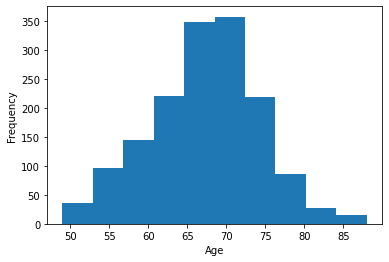

In [7]:
plt.hist(train_df["Age"])
plt.xlabel("Age")
plt.ylabel("Frequency")

Thus maximum patients affected by PF is approximately between 60 and 80

Text(0, 0.5, 'Frquency')

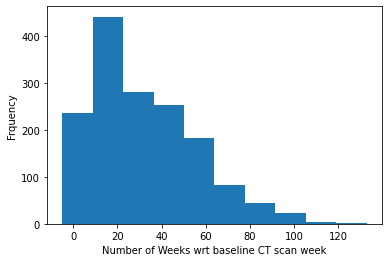

In [8]:
plt.hist(train_df["Weeks"])
plt.xlabel("Number of Weeks wrt baseline CT scan week")
plt.ylabel("Frquency")

Text(0.5, 0, 'FVC')

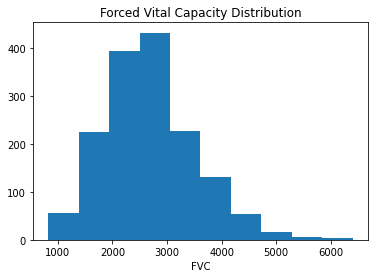

In [9]:
plt.hist(train_df['FVC'])
plt.title("Forced Vital Capacity Distribution")
plt.xlabel("FVC")

Text(0.5, 0, 'Percent of FVC of patients compared to FVC of a normal person')

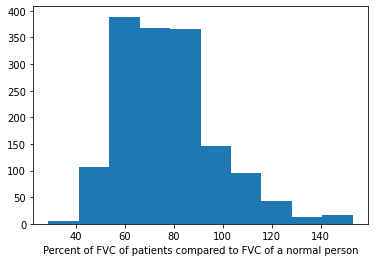

In [10]:
plt.hist(train_df["Percent"])
plt.xlabel("Percent of FVC of patients compared to FVC of a normal person")

Summary of patients having very low FVC: 


Number of patients: 
 23

Smoking status: 
 Ex-smoker       33
Never smoked    19
Name: SmokingStatus, dtype: int64

Sex distribution: 
 Male      42
Female    10
Name: Sex, dtype: int64

Age distribution: 
 (array([ 2.,  0.,  2.,  1., 10., 23.,  2.,  2.,  6.,  4.]), array([52. , 54.5, 57. , 59.5, 62. , 64.5, 67. , 69.5, 72. , 74.5, 77. ]), <BarContainer object of 10 artists>)


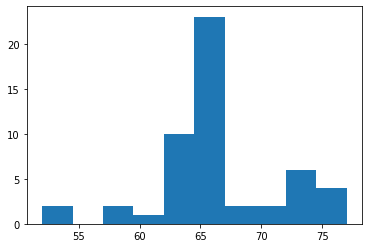

In [11]:
## Analyzing patients where percent is lower than 50%

low_percent_df = train_df[train_df["Percent"] < 50]

print("Summary of patients having very low FVC: \n")
print("\nNumber of patients: \n", low_percent_df['Patient'].nunique())
print("\nSmoking status: \n", low_percent_df['SmokingStatus'].value_counts())
print("\nSex distribution: \n", low_percent_df["Sex"].value_counts())
print("\nAge distribution: \n", plt.hist(low_percent_df["Age"]))

In [12]:
## Colouring the print statements:
from colorama import Fore, Back, Style

print(Fore.YELLOW + "Count of the number of patients in training set: ", Style.RESET_ALL, train_df['Patient'].count())
print(Fore.BLUE + "Count of the number of patients in test set: ", Style.RESET_ALL, test_df['Patient'].count())

Count of the number of patients in training set:   1549
Count of the number of patients in test set:   5


# Visualizing the Images

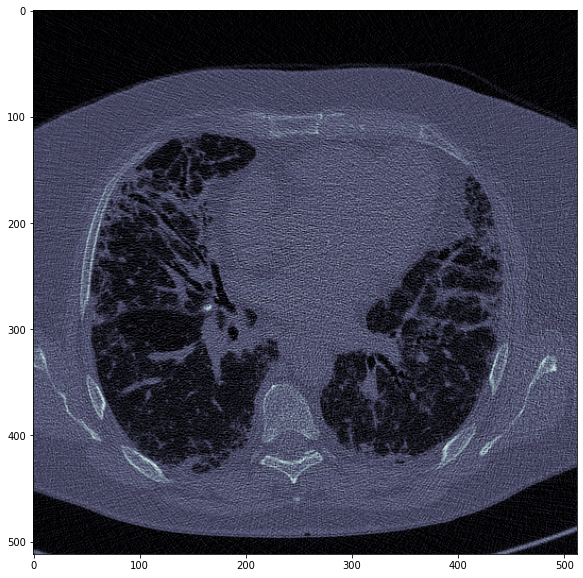

In [13]:
import pydicom

ds = pydicom.dcmread("../input/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140/137.dcm")
plt.figure(figsize=(10,10))
plt.imshow(ds.pixel_array, cmap=plt.cm.bone) 

Getting the 
1. Total number of images, 
2. Average number of images per patient
3. Maximum number of images that a patient has

In [14]:
images_per_directory = []
image_files = 0
patient_directories = 0
path = "../input/osic-pulmonary-fibrosis-progression/train"

for _, train_dirname, patient_filename in os.walk(path):
   #^ The underscore here means that we are not going to use this value/variable in our condition
#     files.append(len(filename))
#     patient_directories.append(len(dirname))
    #print(dirname)
    patient_directories += len(train_dirname) # there is only 1 directory named train with 176 folders
    images_per_directory.append(len(patient_filename)) # adding all the 'number of image files' per patient directory to an array 
    image_files += len(patient_filename) # adding number of images per patient directory

print("Number of patient directories: ", patient_directories)
print("Total number of images: ", image_files)
print("Number of images per patient (on an average): ", int(np.mean(images_per_directory)))
print("Number of images at max that a patient has: ", np.max(images_per_directory))

Number of patient directories:  176
Total number of images:  33026
Number of images per patient (on an average):  186
Number of images at max that a patient has:  1018


Total number of images for Patient with ID ID00007637202177411956430 is:  30


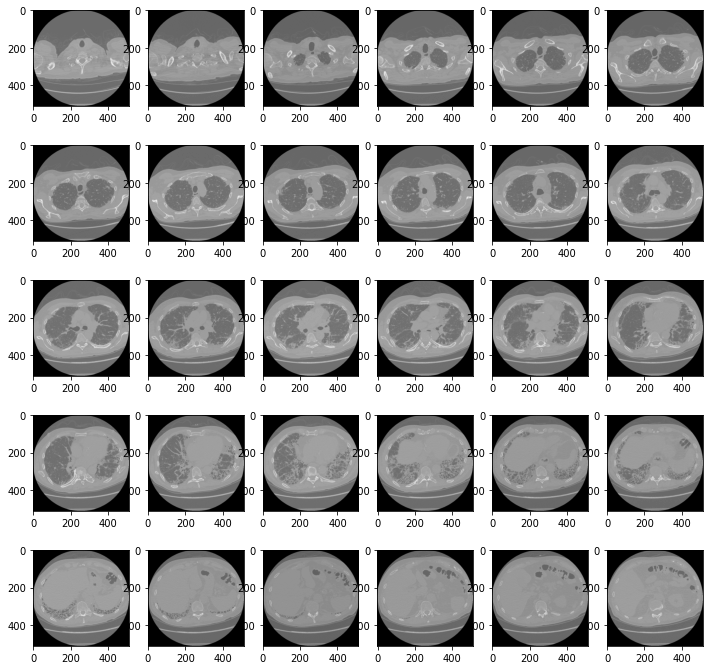

In [15]:
# Fixed order of images from 1 to 30

patient_directory_path = "../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430"
print("Total number of images for Patient with ID ID00007637202177411956430 is: ", len(os.listdir(patient_directory_path)))

fig = plt.figure(figsize=(12,12))
columns = 6
rows =  5

imglist = os.listdir(patient_directory_path)

for i in range(1, rows*columns+1):
    filename = patient_directory_path + "/" + str(i) + ".dcm"
    ds = pydicom.dcmread(filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap='gray')
plt.show()

Total number of images for the Patient ID ID00038637202182690843176:  346


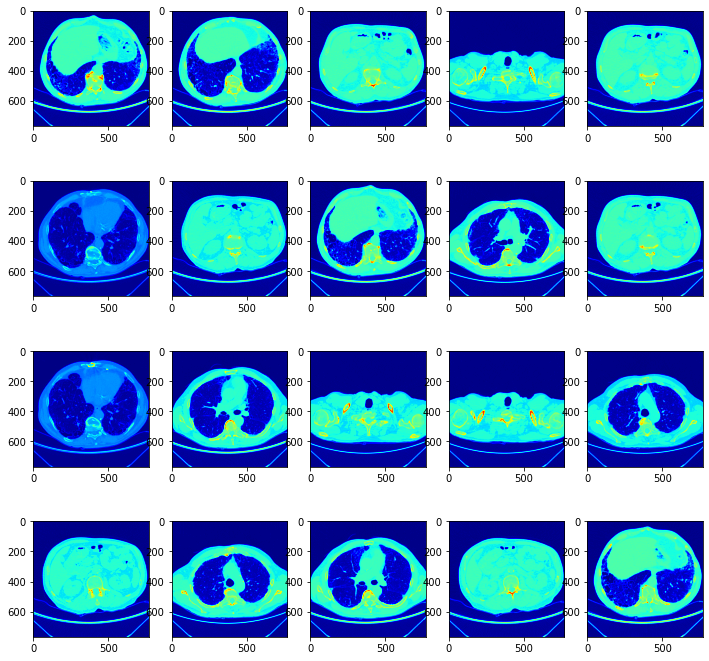

In [16]:
## Random order of images

patient_directory_path = "../input/osic-pulmonary-fibrosis-progression/train/ID00038637202182690843176"

print('Total number of images for the Patient ID ID00038637202182690843176: ', len(os.listdir(patient_directory_path)))

fig = plt.figure(figsize=(12,12))
imglist = os.listdir(patient_directory_path)
columns = 5
rows = 4

for i in range(1, columns*rows + 1):
    image_filename =  patient_directory_path + "/" + str(imglist[i-1])
    ds = pydicom.dcmread(image_filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap = 'jet')

plt.show()

Number of images for the Patient ID ID00032637202181710233084:  205


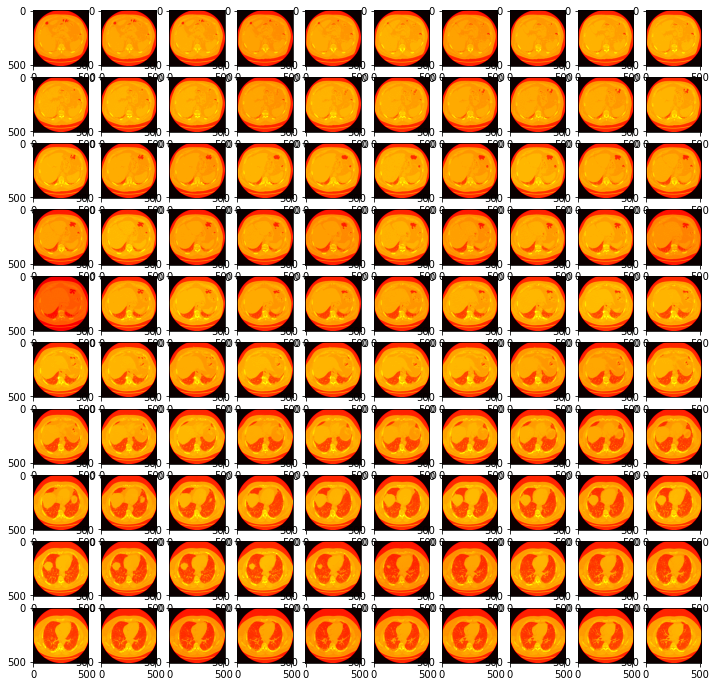

In [17]:
# Fixed order of images from 1 to 100

patient_directory_path = "../input/osic-pulmonary-fibrosis-progression/train/ID00032637202181710233084"
print("Number of images for the Patient ID ID00032637202181710233084: ", len(os.listdir(patient_directory_path)))

fig = plt.figure(figsize= (12,12))
columns = 10
rows = 10

image_list = os.listdir(patient_directory_path)

for i in range(1, columns*rows+1):
    image_filename = patient_directory_path + "/" + str(i) +".dcm"
    ds = pydicom.dcmread(image_filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap = "hot")
    
plt.show()

For color map (cmap) refer to: https://matplotlib.org/stable/tutorials/colors/colormaps.html

## Animated Scans

In [18]:
import pydicom

def load_scan(path):
    # getting images from the patient directory 
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    
    # Image Position (Patient) (0020,0032) specifies the origin of the image with respect to the patient-based coordinate system and 
    # patient based coordinate system is a right handed system. 
    # All three orthogonal planes should share the same Frame of Reference UID (0020,0052) to be spatially related to each other.
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

scans = load_scan("../input/osic-pulmonary-fibrosis-progression/train/ID00052637202186188008618")

In [19]:
!conda install -c conda-forge gdcm -y

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.1               |   py37h89c1867_0         3.1 MB  conda-forge
    gdcm-2.8.9                 |   py37h5d359c0_2         3.4 MB  conda-forge
    libjpeg-turbo-2.0.5        |       h7f98852_0        1002 KB  conda-forge
    -----------------------------

In [20]:
!pip install pillow

In [21]:
import gdcm

In [22]:
# Resample to 1mm (An optional step, it may not be relevant to this competition because of the large slice thickness on the z axis)

from scipy.ndimage.interpolation import zoom
apply_resample= False

def resample(imgs, spacing, new_spacing):
    new_shape = np.round(imgs.shape * spacing / new_spacing)
    true_spacing = spacing * imgs.shape / new_shape
    resize_factor = new_shape / imgs.shape
    imgs = zoom(imgs, resize_factor, mode='nearest')
    return imgs, true_spacing, new_shape

spacing_z = (scans[-1].ImagePositionPatient[2] - scans[0].ImagePositionPatient[2]) / len(scans)

if apply_resample:
    scan_array_resample = resample(scan_array, np.array(np.array([spacing_z, *scans[0].PixelSpacing])), np.array([1.,1.,1.]))[0]

## For animation refer to https://www.kaggle.com/piantic/osic-pulmonary-fibrosis-progression-basic-eda

## Advanced EDA

In [23]:
train_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


<AxesSubplot:xlabel='SmokingStatus', ylabel='count'>

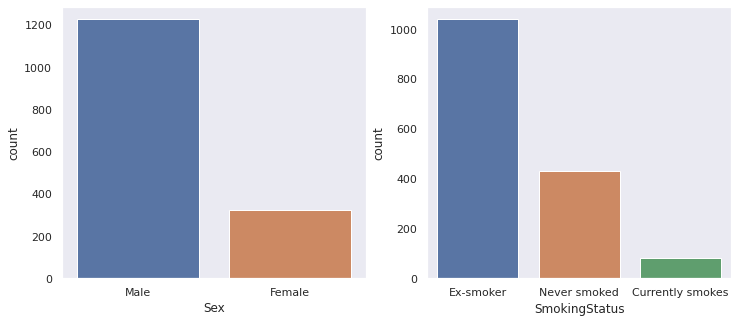

In [24]:
import seaborn as sns

# style in sns include: white, dark, whitegrid, darkgrid, ticks
sns.set_theme(style = 'dark')
f, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))
sns.countplot(data = train_df, x='Sex', ax = axes[0])
sns.countplot(data = train_df, x='SmokingStatus', ax = axes[1])

In [25]:
# Generating correlation map
# getting variables for infering correlation -- excluding patient id
train_df_subset = train_df[['Weeks', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus']]
corr = train_df_subset.corr()
corr

,Weeks,FVC,Percent,Age
Weeks,1.000000,-0.041447,-0.012536,-0.059473
FVC,-0.041447,1.000000,0.671964,-0.094125
Percent,-0.012536,0.671964,1.000000,0.095949
Age,-0.059473,-0.094125,0.095949,1.000000


In [26]:
# Adding mask - Boolean
# Mask will be used in heatmap to show only the upper traingle
mask = np.triu(np.ones_like(corr))
mask

array([[1., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

<AxesSubplot:>

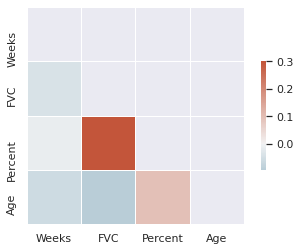

In [27]:

# Generate a custom diverging color map
cmap = sns.diverging_palette(230, 20, as_cmap = True)

# Heatmap
sns.heatmap(corr, mask = mask, cmap = cmap, vmax=0.3, center = 0, square = True, linewidths=0.5, cbar_kws={"shrink": 0.5})

<AxesSubplot:xlabel='Percent', ylabel='Count'>

<Figure size 504x504 with 0 Axes>

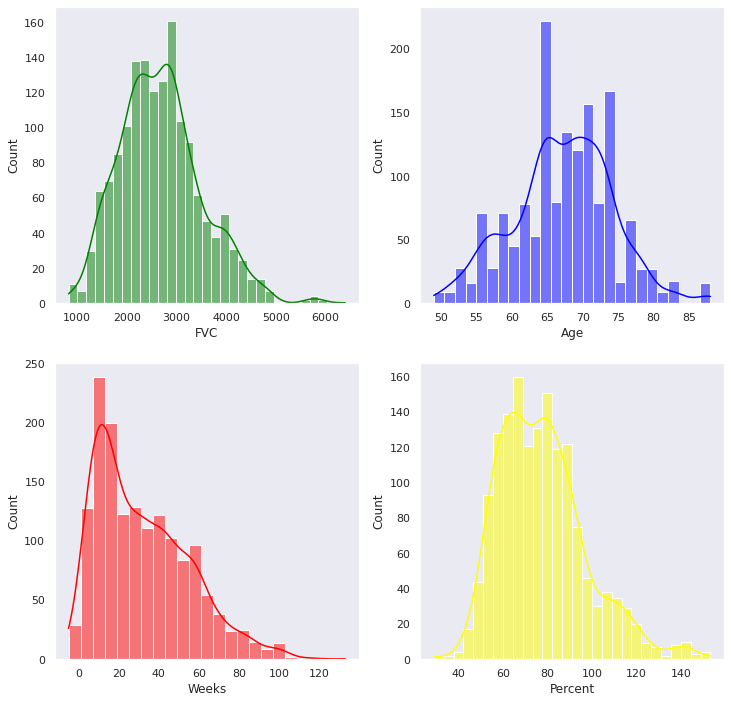

In [28]:
# For continuous variables -- distribution plots
fig = plt.figure(figsize=(7,7))
f,axes = plt.subplots(nrows=2, ncols=2, figsize = (12,12))
sns.histplot(train_df.FVC, color = 'green', kde=True, ax=axes[0][0], legend=True)
sns.histplot(train_df.Age, color = 'blue', kde=True, ax=axes[0][1])
sns.histplot(train_df.Weeks, color = 'red', kde=True, ax=axes[1][0])
sns.histplot(train_df.Percent, color = 'yellow', kde=True, ax=axes[1][1], legend= True)

FVC and Percent across Smoking Status


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<AxesSubplot:xlabel='Percent', ylabel='Density'>

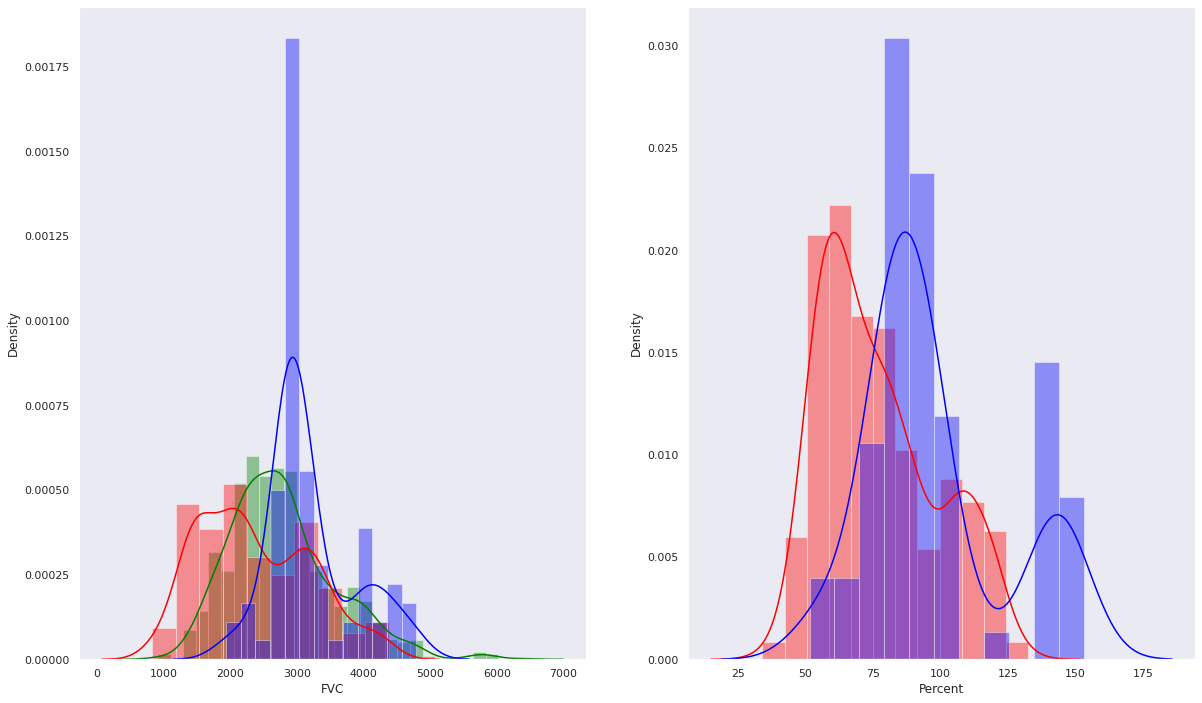

In [29]:
# Multiple level histogram - FVC and Percent across Smoking Status
 
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,12))

print("FVC and Percent across Smoking Status")
sns.distplot(train_df[train_df['SmokingStatus']=='Ex-smoker']['FVC'], color='green', ax = axes[0])
sns.distplot(train_df[train_df['SmokingStatus']=='Never smoked']['FVC'], color='red', ax=axes[0])
sns.distplot(train_df[train_df['SmokingStatus']=='Currently smokes']['FVC'], color='blue', ax=axes[0])

sns.distplot(train_df[train_df['SmokingStatus']=='Ex-Smoker']['Percent'], color='green', ax=axes[1])
sns.distplot(train_df[train_df['SmokingStatus']=='Never smoked']['Percent'], color='red', ax=axes[1])
sns.distplot(train_df[train_df['SmokingStatus']=='Currently smokes']['Percent'], color='blue', ax=axes[1])


1. Never Smokes people also have lower FVC and Percent as compared to Ex-Smokers and Currently smoking people.
2. Thus being something to note about since it is contradictory to our current belief and hypothesis of smoking being major cause of pulmonary fibrosis 
3. We had a smaller subset of people who currently smoke and most of them seem to be concentrated around 3000 FVC
4. We have missing percent data for ex-smokers
5. Ex-smokers seem to be widely spread in terms of FVC so no pattern observed there


FVC and Percent across Sex


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<AxesSubplot:xlabel='Percent', ylabel='Density'>

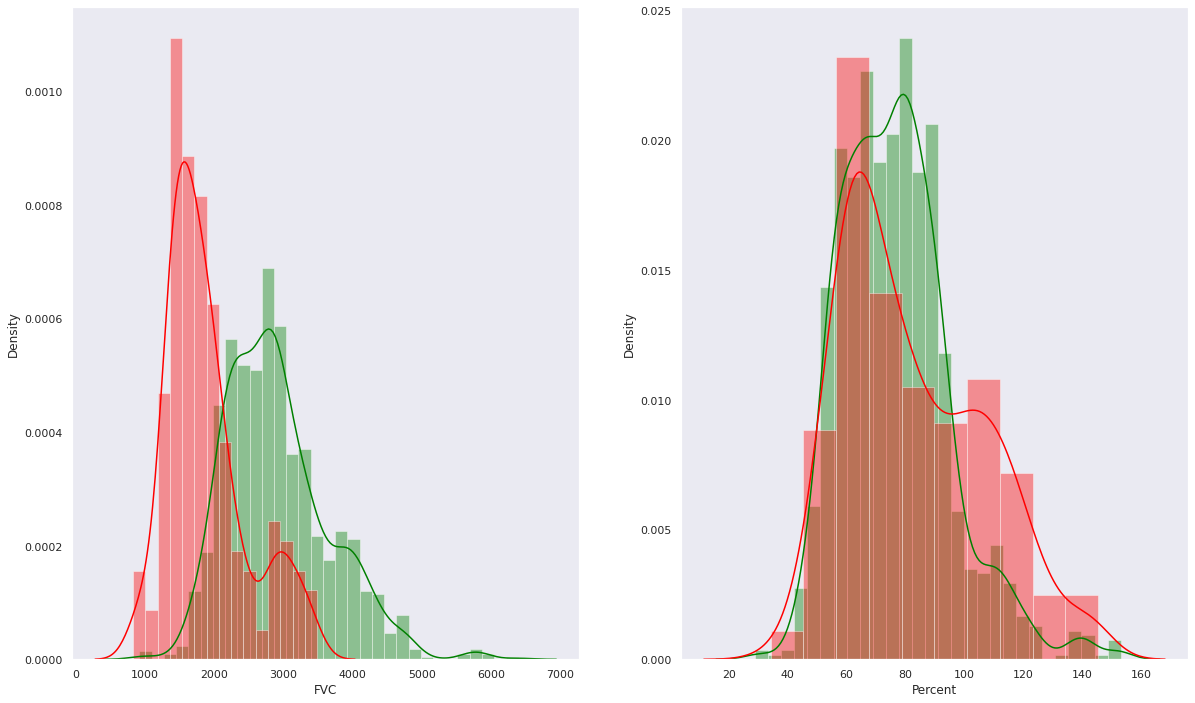

In [30]:
# Multiple level histogram - FVC and Percent across Smoking Status
 
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,12))

print("FVC and Percent across Sex")
sns.distplot(train_df[train_df['Sex']=='Male']['FVC'], color='green', ax = axes[0])
sns.distplot(train_df[train_df['Sex']=='Female']['FVC'], color='red', ax=axes[0])

sns.distplot(train_df[train_df['Sex']=='Male']['Percent'], color='green', ax=axes[1])
sns.distplot(train_df[train_df['Sex']=='Female']['Percent'], color='red', ax=axes[1])


FVC of Males are on an average higher than Females, however when compare with a normal person, there seems to be no pattern difference between males and females

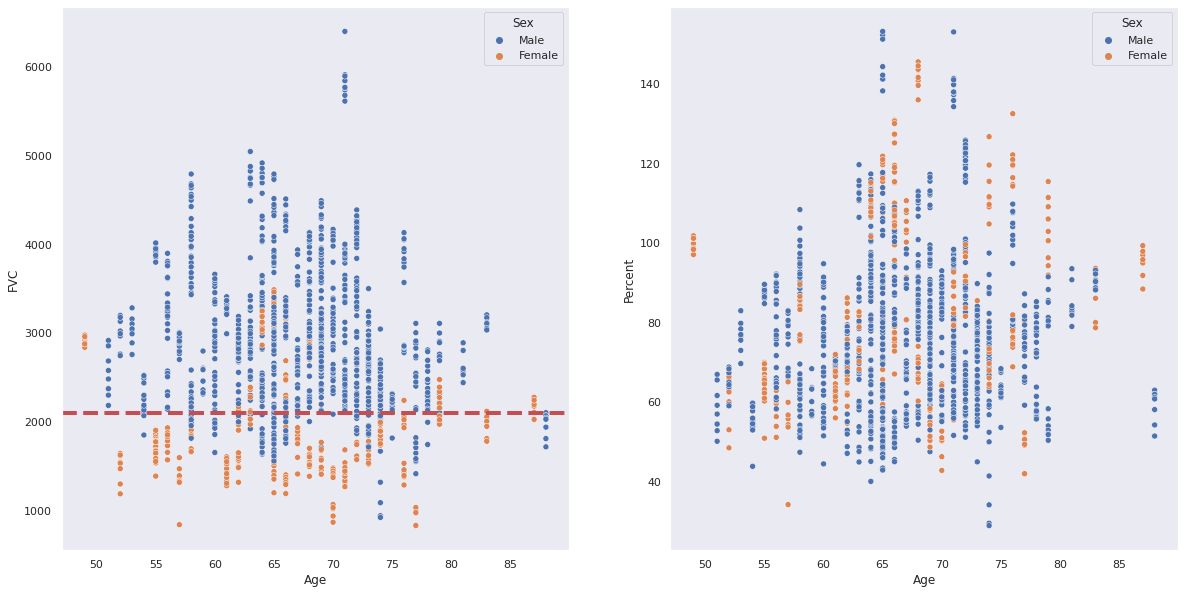

In [31]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
graph1 = sns.scatterplot(data=train_df, x='Age', y='FVC', hue='Sex', ax=axes[0])
graph2 = sns.scatterplot(data=train_df, x='Age', y='Percent', hue='Sex', ax= axes[1])
## to draw a line within the graph
graph1.axhline(y = 2100, linewidth = 4, color = "r", linestyle = '--')
plt.show()

<AxesSubplot:xlabel='Sex', ylabel='Percent'>

<Figure size 720x720 with 0 Axes>

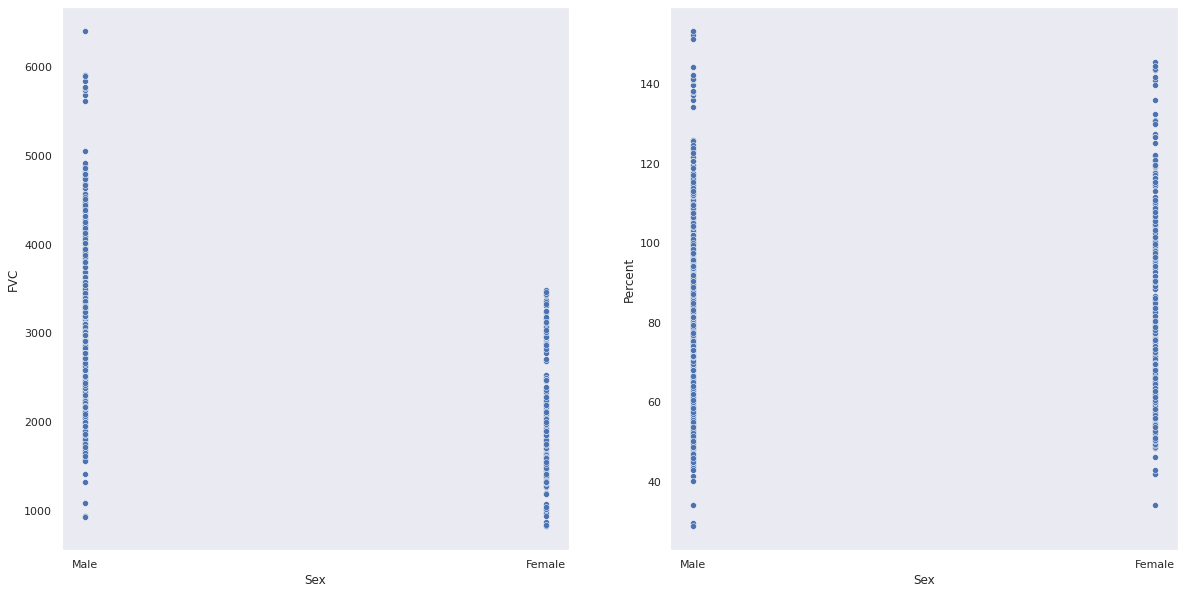

In [32]:
fig = plt.figure(figsize=(10,10))
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
sns.scatterplot(data=train_df, x='Sex', y='FVC', ax=axes[0])
sns.scatterplot(data=train_df, x='Sex', y ='Percent', ax=axes[1])

<Figure size 720x720 with 0 Axes>

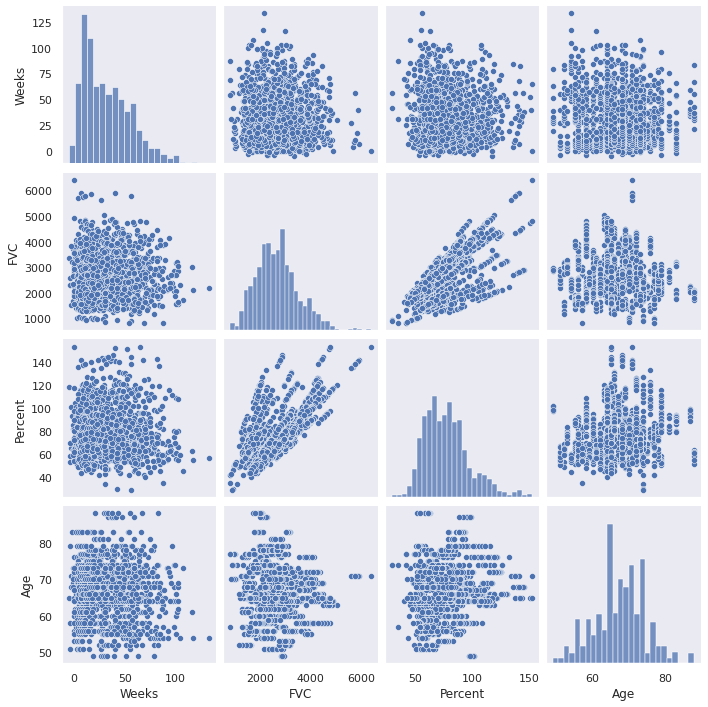

In [33]:
fig = plt.figure(figsize=(10,10))
sns.pairplot(train_df)
plt.show()

## Advanced EDA Part 2

### Single Variable Plots

In [34]:
train_df['SmokingStatus'].value_counts()

Ex-smoker           1038
Never smoked         429
Currently smokes      82
Name: SmokingStatus, dtype: int64

In [35]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable = True)

In [36]:
!pip install chart_studio

     |████████████████████████████████| 64 kB 559 kB/s 


In [37]:
import chart_studio
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot

iplot documentation: http://web.quant-platform.com/trial/yves/Plotly_Cufflinks.html and 
https://plotly.com/python/bar-charts/

In [38]:
train_df['SmokingStatus'].value_counts().iplot(kind='bar',
                                              yTitle='Counts',
                                              xTitle='Smoking Status',
                                              title='Distribution of the Smoking Status column in the Training Set',
                                              linecolor='gray', 
                                              opacity=0.7,
                                              color='red',
                                              theme='solar',
                                              bargap=0.5,
                                              showgrid=False
                                              )

In [39]:
train_df['SmokingStatus'].value_counts().iplot(theme='solar', color='red', showgrid=False)

In [40]:
train_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [41]:
train_df['Weeks'].value_counts().iplot(kind='barh',
                                    xTitle='Count',
                                    yTitle='Weeks',
                                    title='Distribution of Weeks pre/post CT scan in training set',
                                    theme='pearl',
                                    color = '#000058',
                                    bargap = 0.5,   
                                    showgrid=False)

In [42]:
train_df['Weeks'].value_counts()

8     45
12    44
18    42
10    41
6     40
      ..
97     1
96     1
95     1
93     1
91     1
Name: Weeks, Length: 112, dtype: int64

In [43]:
# Distribution of value counts of weeks - Histogram

train_df['Weeks'].value_counts().iplot(kind='hist',
                                    xTitle='Value Counts of Weeks',
                                    yTitle='Count',
                                    title='Distribution of Value Counts of Weeks pre/post CT scan in training set',
                                    theme='pearl',
                                    color='#000058',
                                    bargap = 0.2,   
                                    showgrid=False)

In [44]:
# Distribution of Weeks - Histogram

train_df['Weeks'].iplot(kind='hist',
                              xTitle='Weeks', 
                              yTitle='Counts',
                              linecolor='black', 
                              opacity=0.7,
                              color='#000058',
                              theme='pearl',
                              bargap=0.2,
                              gridcolor='white',
                              title='Distribution of the Weeks in the training set')

In [45]:
train_df['Sex'].value_counts()

Male      1224
Female     325
Name: Sex, dtype: int64

In [46]:
data_gender = [['Male',1224], ['Female', 325]]
df = pd.DataFrame(data_gender, columns=['Sex', 'Value Counts'])
df.head()

,Sex,Value Counts
0,Male,1224
1,Female,325


In [47]:
px.bar(df, 
       color='Sex',
       x= 'Sex',
       y='Value Counts')

In [48]:
train_df['Age'].value_counts()

65    133
69    121
73     98
71     98
68     90
64     89
66     80
72     79
74     69
58     62
70     59
63     53
62     51
67     45
60     45
56     43
76     35
77     31
57     28
55     28
79     27
61     27
78     27
83     18
52     18
75     17
54     16
53     10
81      9
49      9
51      9
59      9
88      9
87      7
Name: Age, dtype: int64

In [49]:
train_df['Age'].value_counts().iplot(kind='bar', 
                                     color='red',
                                     xTitle='Age',
                                     yTitle='Count',
                                     title='Distribution of Age in training set',
                                     opacity=0.7,
                                     showgrid=False)

In [50]:
train_df['FVC'].iplot(kind='hist',
                     xTitle='FVC',
                     yTitle='Number of times this particular FVC occured',
                     theme='solar',
                     showgrid=False)

In [51]:
train_df['Percent'].iplot(kind='hist',
                         theme='solar',
                         xTitle='Percent of normal',
                         title='Distribution of Percent of FVC as compared to Normal FVC in the training set')

In [52]:
import os
os.chdir(r'/kaggle/working')

In [53]:
from IPython.display import FileLink
FileLink(r'*name of file*')

/kaggle/working/*name of file*